In [1]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

class My_Stacking:
    def __init__(self, models:list, meta_alg, data:pd.DataFrame=None, target_columns:list=None, data_train:pd.DataFrame=None, targets_train:pd.DataFrame=None,
                data_test:pd.DataFrame=None, targets_test:pd.DataFrame=None, random_state:int=42, test_size:float=0.2, cv:int=5):
        if target_columns != None:
            self.targets_train = data.loc[:, target_columns]
        elif targets_train != None:
            self.targets_train = targets_train
        else:
            raise ValueError('targets_train or target_columns name not definded')
        
        
        if type(data) != None and target_columns != None:
            self.data_train = data.loc[:, data.columns.drop(target_columns)]
        elif data_train != None:
            self.data_train = data_train
        else:
            raise ValueError('data_train or data and target_columns name not definded')
        
        self.models = models
        self.meta_alg = meta_alg
        self.data_test = data_test
        self.targets_test = targets_test
        self.random_state = random_state
        self.test_size = test_size
        self.cv = cv

        if all(type(x) != None for x in [self.data_train, self.targets_train]):
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data_train, self.targets_train,
                                                                                           random_state=self.random_state, test_size=self.test_size)
        else:
            raise ValueError('Missing data')


    def stacking(self, method:str='predict'):
        if self.test_size is None:
            meta_mtrx = np.empty((self.X_train.shape[0], len(self.models)))

            for n, model in enumerate(self.models):
                meta_mtrx[:, n] = cross_val_predict(model, self.X_train, self.y_train, cv=self.cv, method=method)

            meta_model = self.meta_alg.fit(meta_mtrx, self.y_train)

            meta_mtrx_test = np.empty((self.X_test.shape[0], len(self.models)))

            for n, model in enumerate(self.models):
                meta_mtrx_test[:, n] = model.predict(self.X_test)

            meta_model_pred = meta_model.predict(meta_mtrx_test)
            
            if not (self.targets_test is None):
                rac = roc_auc_score(self.targets_test, meta_model_pred)
                print(rac)
                
            else:
                rac=0

            return meta_model_pred, rac


        elif self.test_size > 0 and self.test_size < 1:
            X_train_, X_test_, y_train_, y_test_ = train_test_split(self.data_train, self.targets_train, test_size=self.test_size,
                                                                    random_state=self.random_state)

            meta_mtrx = np.empty((X_train_.shape[0], len(self.models)))
            meta_mtrx_test = np.empty((self.data_test.shape[0], len(self.models)))

            for n, model in enumerate(self.models):
                model = model.fit(X_train_, y_train_)
                meta_mtrx[:, n] = model.predict(X_train_)
                meta_mtrx_test[:, n] = model.predict(self.data_test)

            meta_model = self.meta_alg.fit(meta_mtrx, y_train_)
            meta_model_pred = meta_model.predict(meta_mtrx_test)

            if not (self.targets_test is None):
                rac = roc_auc_score(self.targets_test, meta_model_pred)
                print(rac)
                
            else:
                rac=0


            return meta_model_pred, rac

        else:
            raise ValueError("test_size must be between 0 and 1")

In [2]:
# Load in the train and test datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [6]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,1,0,0,A.5. 3236,1,NaN,0,18,0,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,2,0,0,PC 17758,3,C105,1,28,1,1,1,5
415,1307,3,"Saether, Mr. Simon Sivertsen",1,2,0,0,SOTON/O.Q. 3101262,0,NaN,0,28,0,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,2,0,0,359309,1,NaN,0,19,0,1,1,1


<Axes: title={'center': 'Pearson Correlation of Features'}>

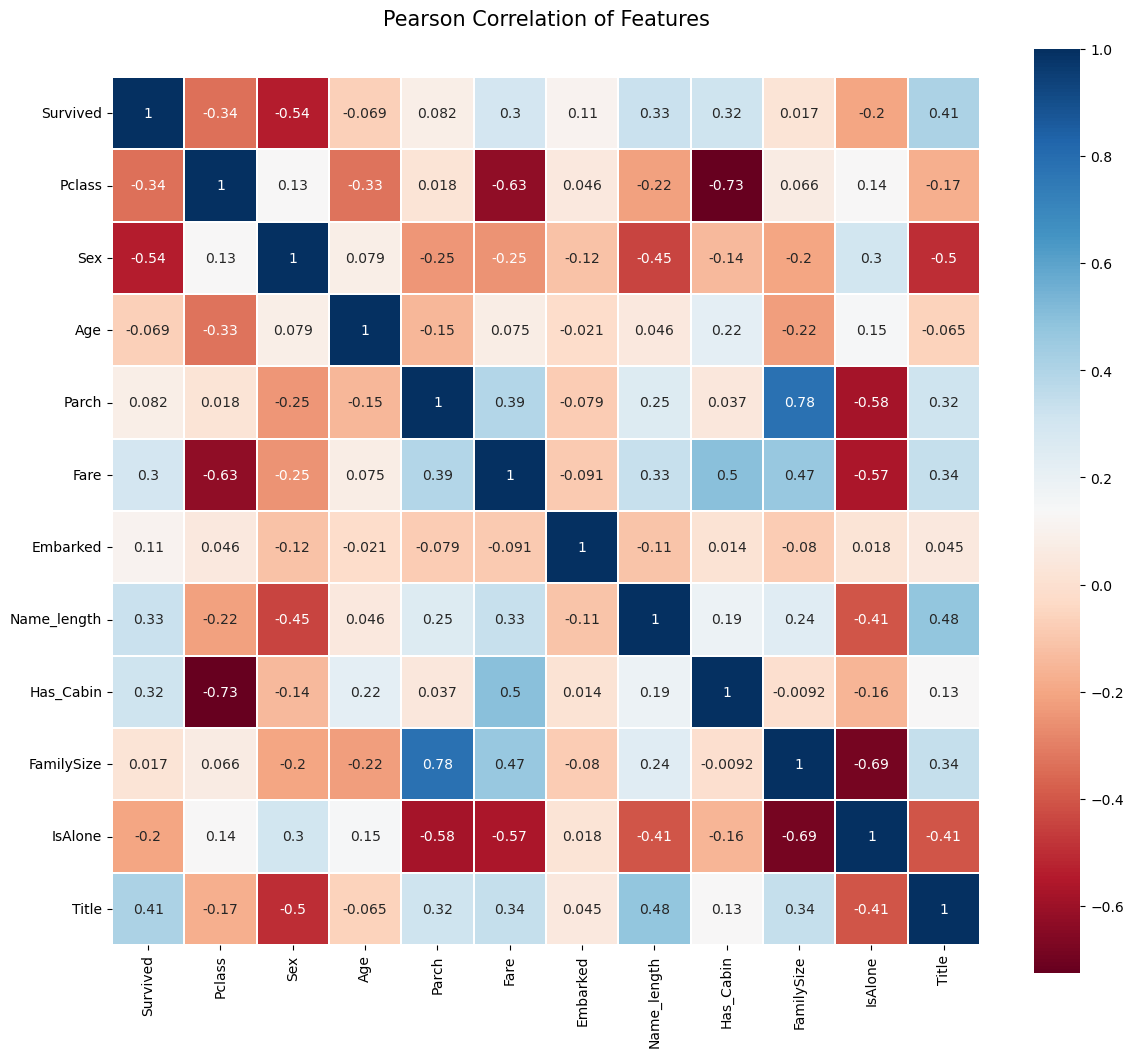

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

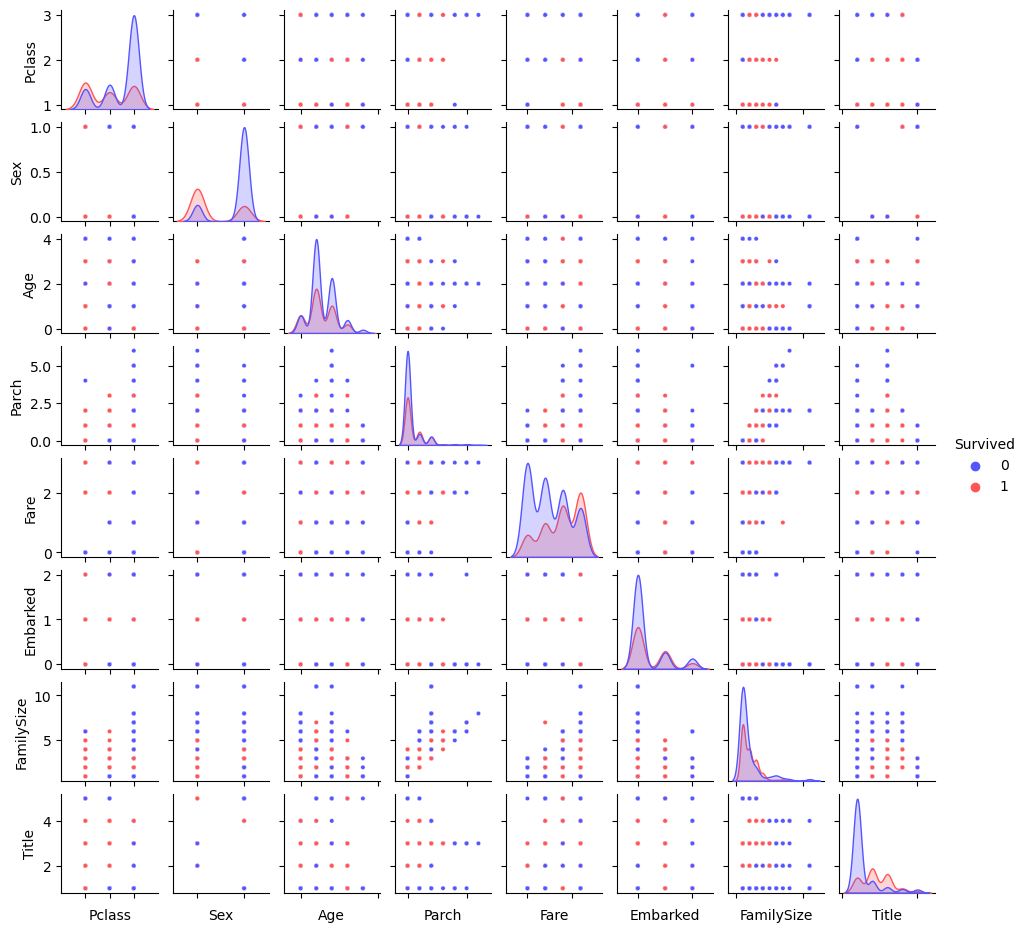

In [8]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

## Построение модели
### 1.
Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания (<b>1 ячейка</b>). В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:


In [9]:
%%time

from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1), # GradientBoostingClassifier
             'random_state': [17]} 

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
             'min_samples_leaf': range(1, 5),
             'random_state': [17]}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
             'C': np.arange(0.1, 1, 0.2),
             'random_state': [17]}

lr_params = {'C': np.arange(0.5, 1, 0.1),
            'random_state': [17]}

skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)

meta_alg = XGBClassifier()


X_train, X_test, y_train, y_test = train_test_split(train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived'],
                                                    random_state=17)

rfc_best_params = GridSearchCV(
        estimator=RandomForestClassifier(), param_grid=rfc_params, cv = skf
    ).fit(
        train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived']
    ).best_params_

rfc = RandomForestClassifier(**rfc_best_params)

svc_best_params = GridSearchCV(
        estimator=SVC(), param_grid=svc_params, cv = skf
    ).fit(
        train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived']
    ).best_params_

svc = SVC(**svc_best_params)


lr_best_params = GridSearchCV(
        estimator=LogisticRegression(), param_grid=lr_params, cv = skf
    ).fit(
        train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived']
    ).best_params_

lr = LogisticRegression(**lr_best_params)

gbc_best_params = GridSearchCV(
        estimator=GradientBoostingClassifier(), param_grid=gbc_params, cv = skf
    ).fit(
        train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived']
    ).best_params_

gbc = GradientBoostingClassifier(**gbc_best_params)

models = [rfc, svc, gbc, lr]
params = [rfc_best_params, svc_best_params, gbc_best_params, lr_best_params]

CPU times: total: 14.9 s
Wall time: 14.9 s


### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [73]:
for i in range(len(models)):
    print(models[i])
    print('RAC:', roc_auc_score(y_train, models[i].fit(X_train, y_train).predict(X_train)), '\n')

RandomForestClassifier(min_samples_leaf=4, n_estimators=20, random_state=17)
RAC: 0.8545071770334928 

SVC(C=0.1, kernel='linear', random_state=17)
RAC: 0.7870334928229664 

GradientBoostingClassifier(random_state=17)
RAC: 0.8864688995215311 

LogisticRegression(C=0.5, random_state=17)
RAC: 0.8054066985645932 



### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [74]:
xgb_params = {'n_estimators': range(10, 25, 5),
              'eta': np.arange(0.1, .6, .1),
              'min_child_weight': range(1, 5, 1),
              'subsample': np.arange(0.1, 1, 0.2),
              'tree_method':['gpu_hist']}

In [77]:
!nvidia-smi

Sat Jul  8 18:58:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              14W / 130W |    164MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [80]:
xgb_best_params = GridSearchCV(estimator=XGBClassifier(tree_method='gpu_hist'), param_grid=xgb_params, cv=skf).fit(
        train.loc[:, train.columns.drop('Survived')], train.loc[:, 'Survived']
    ).best_params_

meta_alg = XGBClassifier(**xgb_best_params)

Sat Jul  8 19:01:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              17W / 130W |    228MiB /  6144MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [81]:
print('XGBClassifier:', xgb_best_params)

XGBClassifier: {'eta': 0.2, 'min_child_weight': 2, 'n_estimators': 15, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [82]:
stack = My_Stacking(models=models, meta_alg=meta_alg, data=train, target_columns=['Survived'], data_test=test,
                random_state=17, test_size=0.3)
meta_pred, meta_rac = stack.stacking()
meta_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [83]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [84]:
dataset.loc[:, 'PassengerId']

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [85]:
write_to_submission_file(predictions=meta_pred, PassengerID=dataset.loc[:, 'PassengerId'])

### 6.
Каков результат score, полученного на соревновании?

In [1]:
0.7519

0.7519

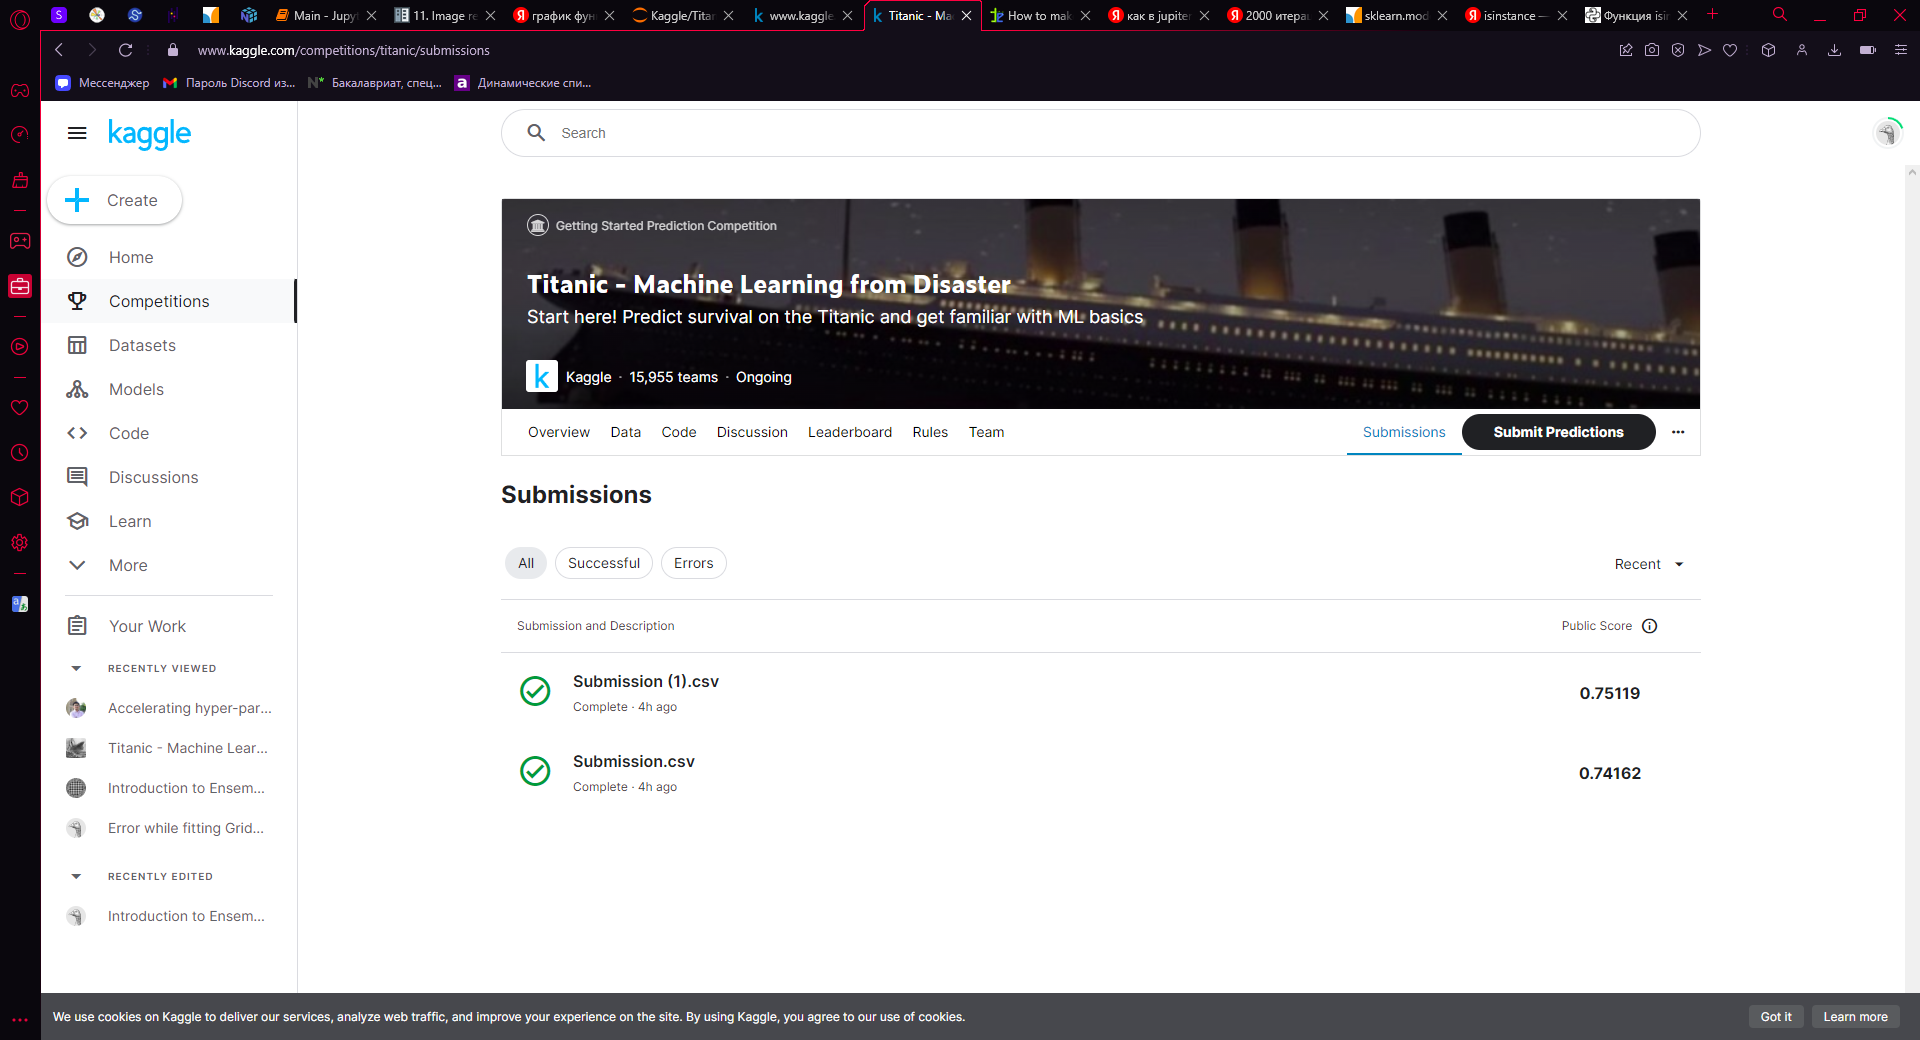